In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('downPackets.csv', sep= ";")

In [3]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,fdev,ipol,prea,size,data,ncrc
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,33,IB9CLTWIvANzFRobSHpfDItCRiVKLq7ZBuDwrAXT8Uk+,1
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAAADUP8AAQYBWQxO,1
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAQADUf8AAQYnNE+f,1
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAgADUf8AAQb82c+D,1
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,Nan,1,Nan,18,YHnpCyaGAwADUf8AAQZbuxCb,1


In [4]:
df.shape

(503, 16)

### Decoding Data Column

In [5]:
import base64
from pprint import pprint

def decode_lorawan_packet(base64_packet):
    try:
        # Decode the base64 packet into bytes
        packet_bytes = base64.b64decode(base64_packet)

        # Initialize an empty dictionary to store packet components
        packet_dict = {}

        # Extracting the MHDR (Message Header)
        packet_dict['MHDR'] = packet_bytes[0]
        packet_dict['MType'] = (packet_bytes[0] >> 5) & 0x07
        packet_dict['RFU'] = (packet_bytes[0] >> 2) & 0x07
        packet_dict['Major'] = packet_bytes[0] & 0x03

        # Extract DevAddr (4 bytes, little-endian)
        devaddr_bytes = packet_bytes[1:5]
        packet_dict['DevAddr'] = devaddr_bytes[::-1].hex()

        # FCtrl (Frame Control)
        packet_dict['FCtrl'] = packet_bytes[5]

        # FCnt (Frame Counter, 2 bytes, little-endian)
        fcnt_bytes = packet_bytes[6:8]
        packet_dict['FCnt'] = int.from_bytes(fcnt_bytes, byteorder='little')

        # Optional FOpts (Frame Options), its length depends on the lower 4 bits of FCtrl
        fopts_length = packet_dict['FCtrl'] & 0x0F
        fopts_end = 8 + fopts_length
        packet_dict['FOpts'] = packet_bytes[8:fopts_end].hex() if fopts_length > 0 else None

        # FPort (1 byte after FOpts, if present)
        if len(packet_bytes) > fopts_end:
            packet_dict['FPort'] = packet_bytes[fopts_end]
            fopts_end += 1
        else:
            packet_dict['FPort'] = None

        # FRMPayload (remaining bytes after FPort)
        if len(packet_bytes) > fopts_end:
            packet_dict['FRMPayload'] = packet_bytes[fopts_end:].hex()
        else:
            packet_dict['FRMPayload'] = None

        return packet_dict
    except:
        return None

In [6]:
decoded_df = df["data"].apply(decode_lorawan_packet).apply(pd.Series)

df = pd.concat([df.drop(columns=["data"]), decoded_df], axis=1)

In [7]:
df.head()

,id,imme,tmst,tmms,freq,rfch,powe,modu,datr,codr,...,MHDR,MType,RFU,Major,DevAddr,FCtrl,FCnt,FOpts,FPort,FRMPayload
0,1,0,1729162410,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,32,1,0,0,352d421f,136,956,73151a1b487a5f0c,139,4246254a2eaed906e0f0ac05d3f1493e
1,2,0,1729162418,Nan,867.9,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,0,0350ff000106,1,590c4e
2,3,0,1729162436,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,1,0351ff000106,39,344f9f
3,4,0,1729162454,Nan,868.1,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,2,0351ff000106,252,d9cf83
4,5,0,1729162472,Nan,868.3,0,14,LORA,SF9BW125,4/5,...,96,3,0,0,260be979,134,3,0351ff000106,91,bb109b


In [8]:
df.columns

Index(['id', 'imme', 'tmst', 'tmms', 'freq', 'rfch', 'powe', 'modu', 'datr',
       'codr', 'fdev', 'ipol', 'prea', 'size', 'ncrc', 'MHDR', 'MType', 'RFU',
       'Major', 'DevAddr', 'FCtrl', 'FCnt', 'FOpts', 'FPort', 'FRMPayload'],
      dtype='object')

In [9]:
df.shape

(503, 25)

In [10]:
df.duplicated().sum() #No duplicate rows

0

In [11]:
len(df["DevAddr"].unique()) #208 end devices

208

In [12]:
# Show count of NaNs per column
nan_counts = df.isna().sum()

# Display only columns with at least one NaN
print(nan_counts[nan_counts > 0])

FOpts    139
dtype: int64


In [13]:
df_valid_packets = df[df['FRMPayload'].notnull()]

### FPort Analysis

In [14]:
df_valid_packets["FPort"].unique()

array([139,   1,  39, 252,  91, 165, 253, 202, 133,  82, 228, 222,   0,
       159, 119,  97, 162,  16, 245,  65, 104, 194, 153,  54, 198,  52,
       106, 163, 137, 240, 157, 192, 237, 220, 195, 134, 178, 124, 255,
       123, 102, 111, 126, 127, 227, 236, 196,  45, 211,  49, 224,  17,
        75,  47, 241, 128, 108, 112, 193, 107,  32, 176, 201,  24,  64,
       147,  21, 148,  27, 248, 205,  48,   4, 138, 189,  74, 254, 238,
       180,  18, 229, 151, 174, 199,  10, 204, 234,  33,  58,  31,  34,
        23, 231,  37,  87, 181,  46,  42, 218, 144,  25, 225, 158, 117,
       203, 164, 186,   7,   5, 213,  35, 242,  26, 207, 184, 217,  89,
        67, 105, 249, 118, 209,  55,  96, 120,  71,  88,  28, 190, 113,
        98,  30,  77,  59,  81,  93, 169, 101, 251, 142,  62,  11, 175,
        53,  22, 146,  14, 150, 191, 182, 216,   6, 145, 152, 185, 114,
       143,  69,  19, 140,  94, 121, 135, 215, 154,  86,  29, 188,   8,
       110, 130, 149, 166,   3,  51, 214, 161,  40,  76,  63,   

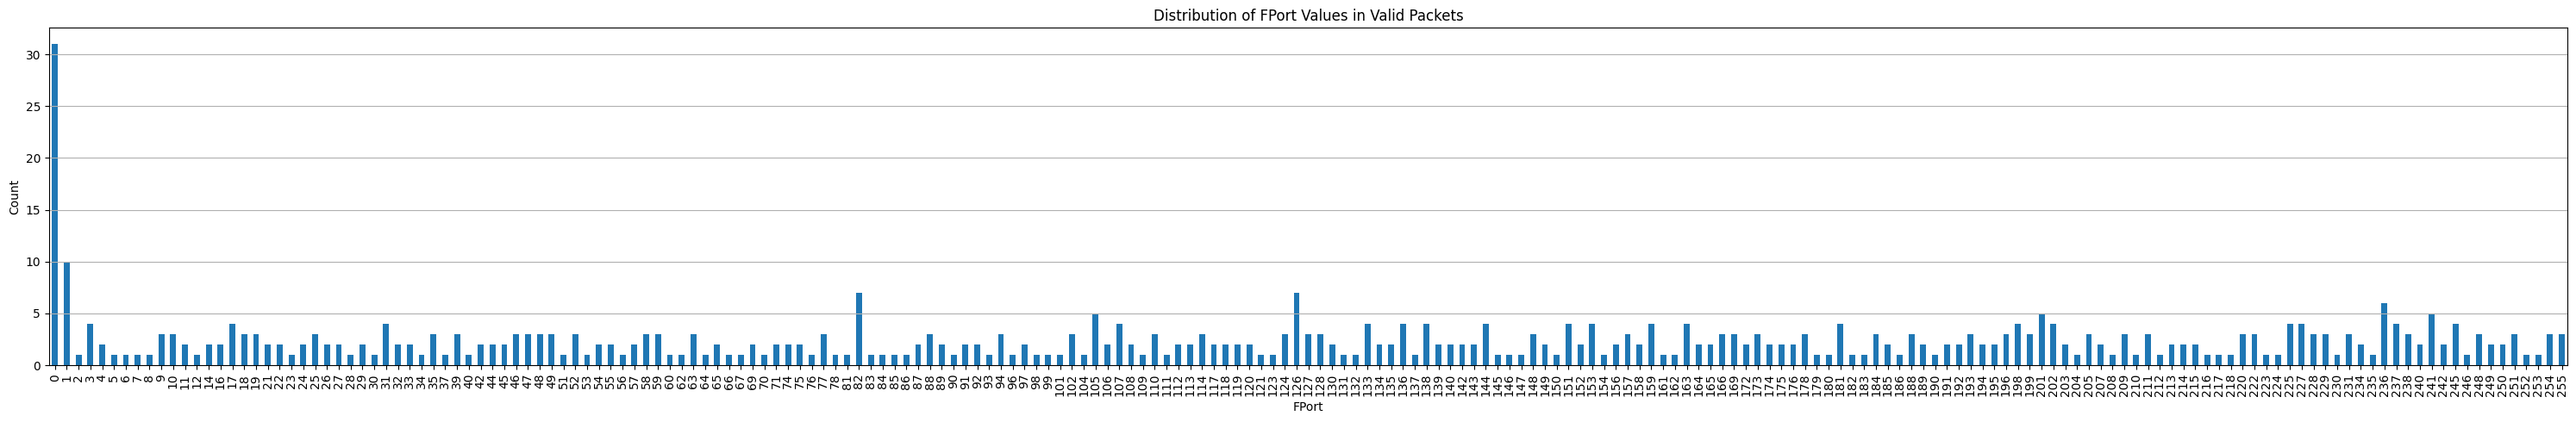

In [15]:
# Create a histogram (bar chart) of the FPort column
fport_counts = df_valid_packets["FPort"].value_counts().sort_index()

plt.figure(figsize=(30, 5))
fport_counts.plot(kind='bar')
plt.xlabel("FPort")
plt.ylabel("Count")
plt.title("Distribution of FPort Values in Valid Packets")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:
# Count FPort occurrences
fport_counts = df_valid_packets["FPort"].value_counts()

# Identify FPorts in the 244–255 range (Special Use)
special_use_fports = fport_counts[fport_counts.index >= 244]
special_use_sum = special_use_fports.sum()

# Remove special use FPorts from the main counts temporarily
fport_counts_cleaned = fport_counts.drop(special_use_fports.index, errors='ignore')

# Get the top 6 FPorts from the cleaned counts
top_6 = fport_counts_cleaned.head(6)

# Remove those top 6 from cleaned to find the rest (Others)
remaining_fports = fport_counts_cleaned.drop(top_6.index, errors='ignore')
others_sum = remaining_fports.sum()

# Combine all into final Series
final_series = pd.concat([
    top_6,
    pd.Series({'Special Use': special_use_sum}),
    pd.Series({'Others': others_sum})
])

# Convert to lists
labels = final_series.index.tolist()
values = final_series.values.tolist()

# Plot
fig = go.Figure(data=[
    go.Pie(labels=labels, values=values, pull=[0, 0.2, 0, 0, 0, 0, 0, 0], textinfo='label+percent')
])

fig.update_layout(
    title=dict(
        text="FPort Distribution for Valid Packets",
        font=dict(size=24),
        x=0.5,
        xanchor='center'
    ),
    legend_title="FPorts",
    legend=dict(font=dict(size=14)),
    width=800,
    height=600
)

fig.show()

FPort_category
Application    405
Reserved        67
Control         31
Name: count, dtype: int64


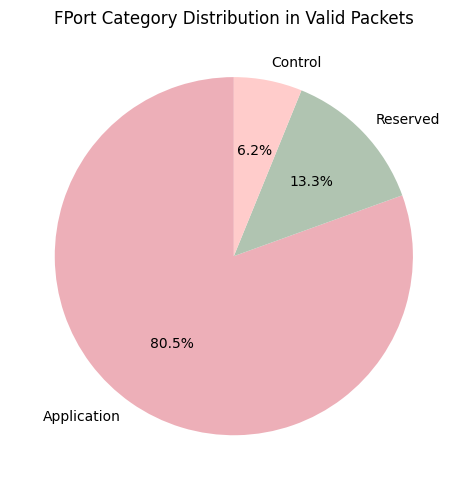

In [17]:
# Filter only packets with valid payload
valid_packets = df[df['FRMPayload'].notnull()]

# Function to categorize FPort values
def categorize_fport(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Apply categorization to create a new column
valid_packets['FPort_category'] = valid_packets['FPort'].apply(categorize_fport)

# Count the number of packets in each category
category_counts = valid_packets['FPort_category'].value_counts()

print(category_counts)

# Optional: Plot the distribution as a pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#edafb8', '#b0c4b1', '#ffcccb'])
plt.title('FPort Category Distribution in Valid Packets')
plt.ylabel('')  # Remove the default label
plt.tight_layout()
plt.show()


### Device Count by Number of Packets Sent

Maximum number of packets sent by a device: 57


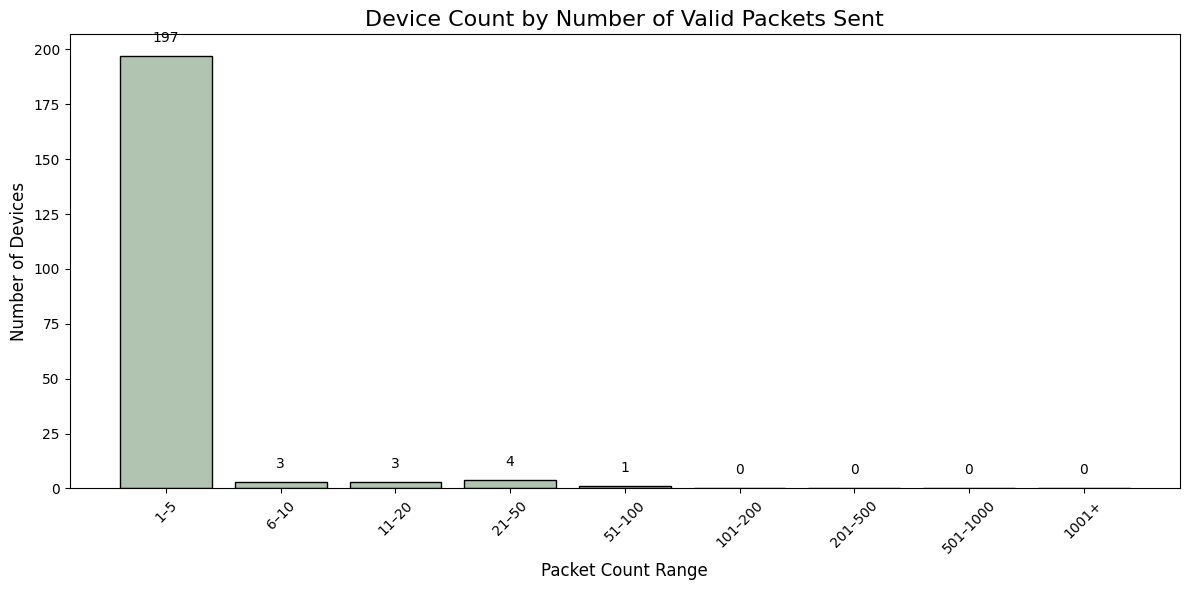

In [18]:
# Count how many packets per DevAddr
devaddr_counts = df_valid_packets['DevAddr'].value_counts()
print("Maximum number of packets sent by a device:", devaddr_counts.max())
# Define bins and labels
bins = [1, 6, 11, 21, 51, 101, 201, 501, 1001, float('inf')]
labels = ['1–5', '6–10', '11–20', '21–50', '51–100', '101–200', '201–500', '501–1000', '1001+']

# Bin the device packet counts
binned = pd.cut(devaddr_counts, bins=bins, labels=labels, right=False)
binned_counts = binned.value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(binned_counts.index.astype(str), binned_counts.values, edgecolor='black', color='#b0c4b1')
plt.title('Device Count by Number of Valid Packets Sent', fontsize=16)
plt.xlabel('Packet Count Range', fontsize=12)
plt.ylabel('Number of Devices', fontsize=12)
plt.xticks(rotation=45)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

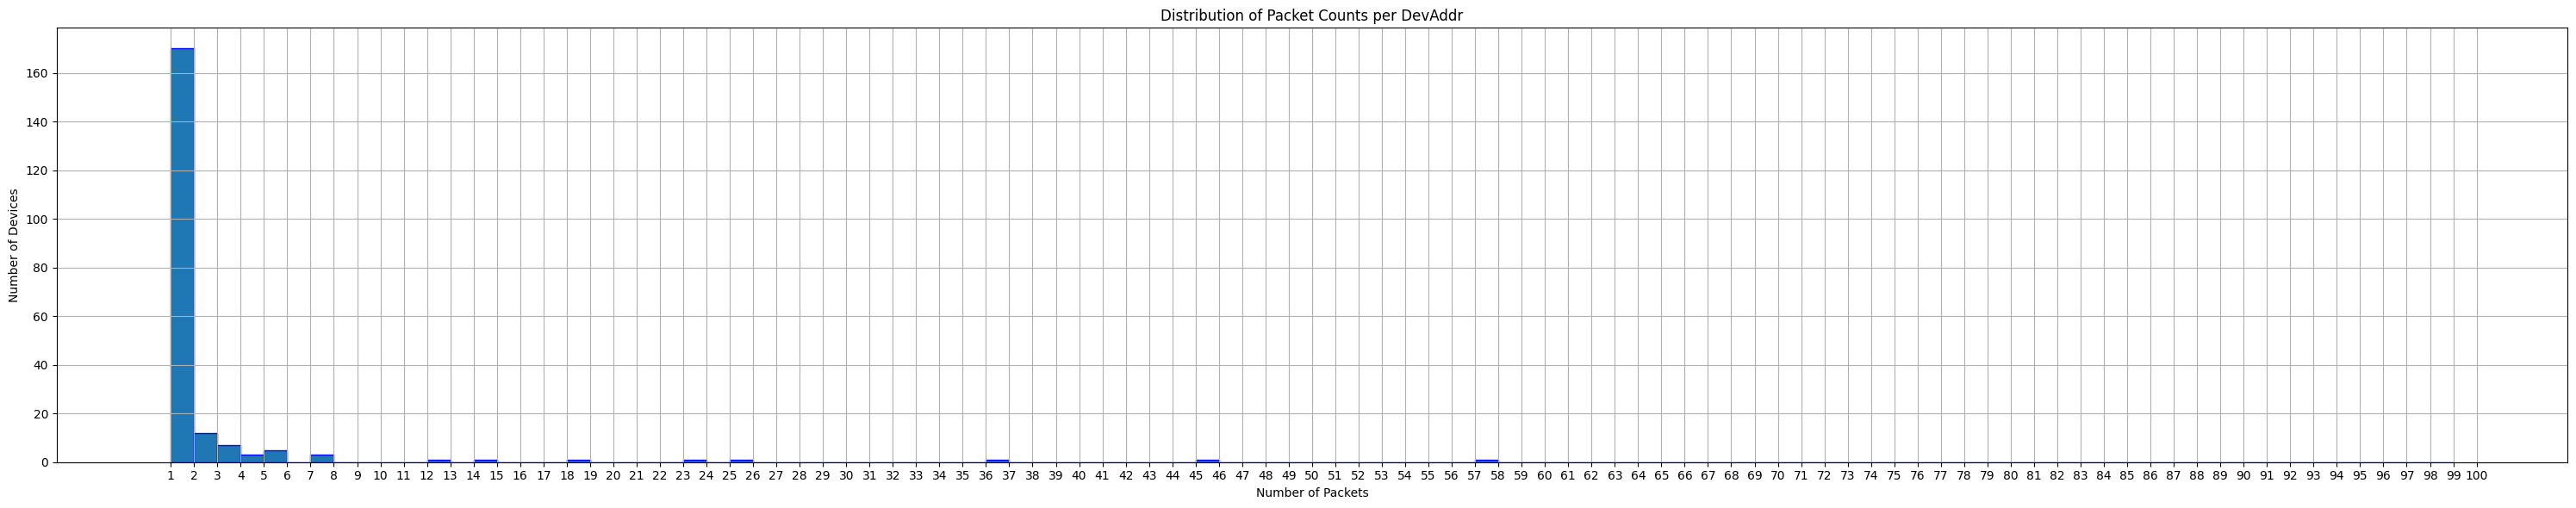

In [19]:
# A close up histogram
plt.figure(figsize=(30, 6))
plt.hist(devaddr_counts, bins=range(1, 100), edgecolor='blue')
plt.title('Distribution of Packet Counts per DevAddr')
plt.xlabel('Number of Packets')
plt.ylabel('Number of Devices')
plt.grid(True)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

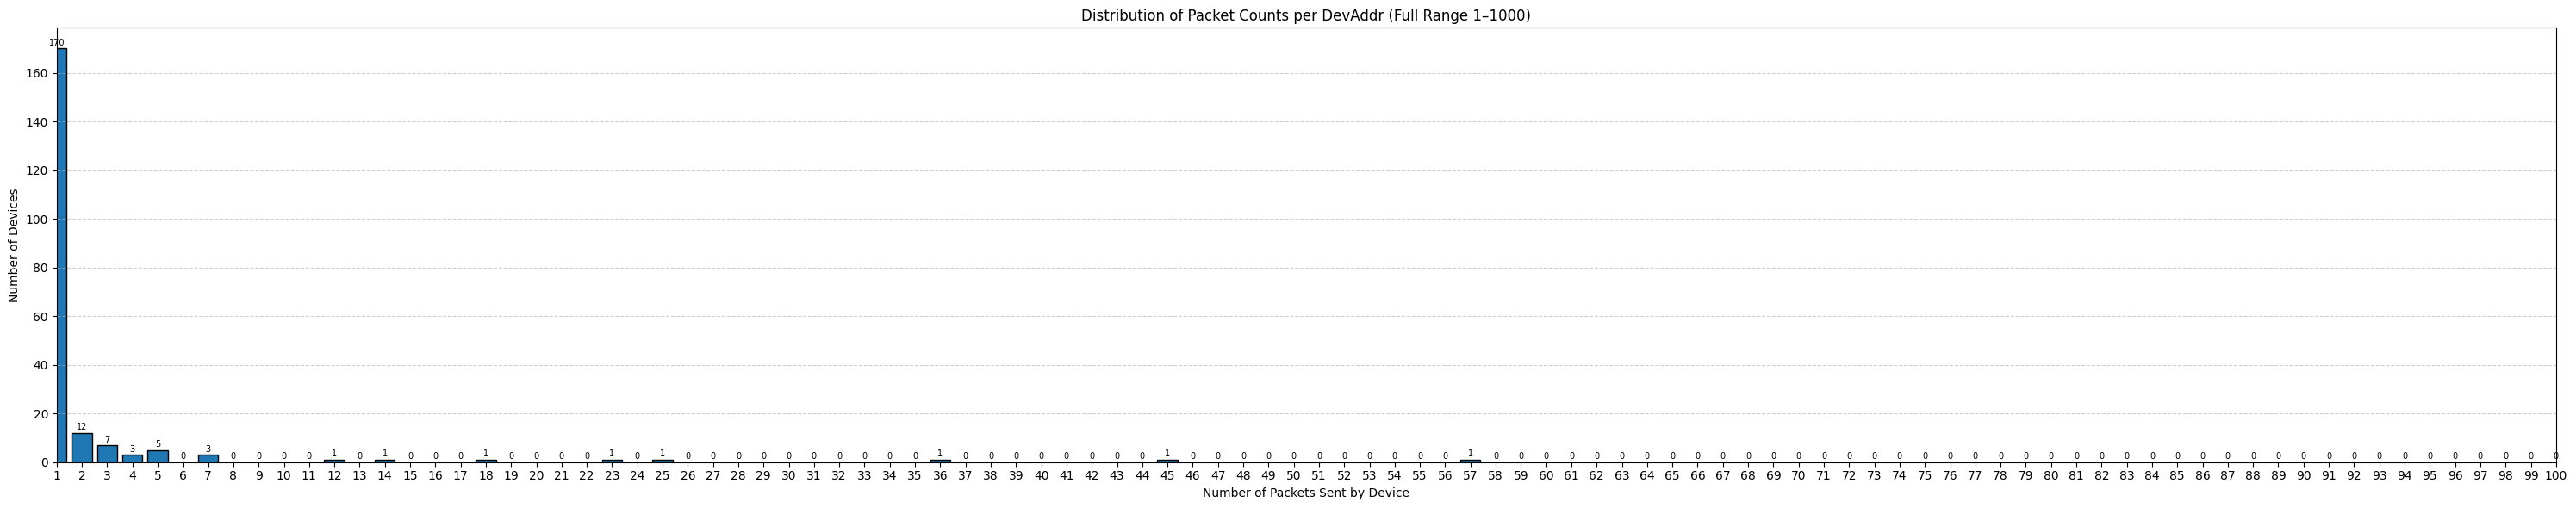

In [20]:
# Count how many devices sent X packets
packet_distribution = devaddr_counts.value_counts().sort_index()

# Ensure full x-axis from 1 to 1000
full_range = pd.Series(index=range(1, 101), dtype=int)
packet_distribution = packet_distribution.reindex(full_range.index, fill_value=0)

# Plot bar chart
plt.figure(figsize=(30, 6))
bars = plt.bar(packet_distribution.index, packet_distribution.values, edgecolor='black')

# Optionally add labels (skip if too crowded)
for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)),
  ha='center', va='bottom', fontsize=7)

plt.title('Distribution of Packet Counts per DevAddr (Full Range 1–1000)')
plt.xlabel('Number of Packets Sent by Device')
plt.ylabel('Number of Devices')
plt.xlim(1, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.xticks(ticks=range(1, 101))
plt.show()

### SF Histogram

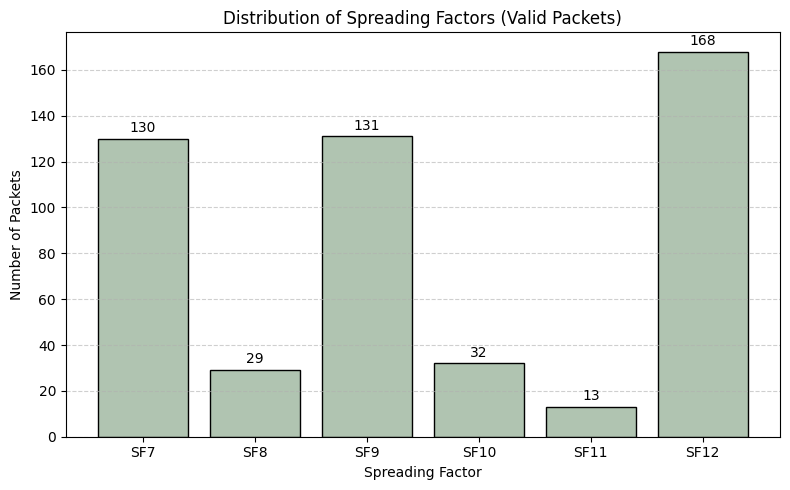

In [21]:
# Extract numeric SF
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(float)

# Count, sort numerically, and relabel
sf_counts_valid = df_valid_packets['sf_num'].value_counts().sort_index()
sf_labels = [f'SF{int(sf)}' for sf in sf_counts_valid.index]  # relabel x-axis

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(sf_labels, sf_counts_valid.values, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Spreading Factors (Valid Packets)')
plt.xlabel('Spreading Factor')
plt.ylabel('Number of Packets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(sf_counts_valid.values) * 0.01,  # Slight vertical offset
        str(int(height)),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [35]:
# Filter for high spreading factors
high_sf = [12, 11]
df_high_sf = df_valid_packets[df_valid_packets['sf_num'].isin(high_sf)]

# Count high SF packets per device (DevAddr)
device_high_sf_counts = df_high_sf['DevAddr'].value_counts().reset_index()
device_high_sf_counts.columns = ['DevAddr', 'HighSF_PacketCount']

# Add total packet count per device for percentage
device_total_counts = df_valid_packets['DevAddr'].value_counts().reset_index()
device_total_counts.columns = ['DevAddr', 'TotalPacketCount']

# Merge to get percentage of high SF packets per device
device_sf_summary = pd.merge(device_total_counts, device_high_sf_counts, on='DevAddr', how='left')
device_sf_summary['HighSF_PacketCount'] = device_sf_summary['HighSF_PacketCount'].fillna(0).astype(int)
device_sf_summary['HighSF_Percentage'] = (
    device_sf_summary['HighSF_PacketCount'] / device_sf_summary['TotalPacketCount'] * 100
).round(2)

# Sort to see top high-SF users
device_sf_summary = device_sf_summary.sort_values(
    by=['HighSF_Percentage', 'HighSF_PacketCount'],
    ascending=[False, False]
)

device_sf_summary.head(40)

,DevAddr,TotalPacketCount,HighSF_PacketCount,HighSF_Percentage
0,260b4e20,57,57,100.00
7,260b762a,12,12,100.00
19,260b9ed5,3,3,100.00
21,260b6147,3,3,100.00
31,260bd022,2,2,100.00
36,260b554e,2,2,100.00
41,869ff24f,1,1,100.00
46,bb21602e,1,1,100.00
48,07258761,1,1,100.00
53,d1791038,1,1,100.00


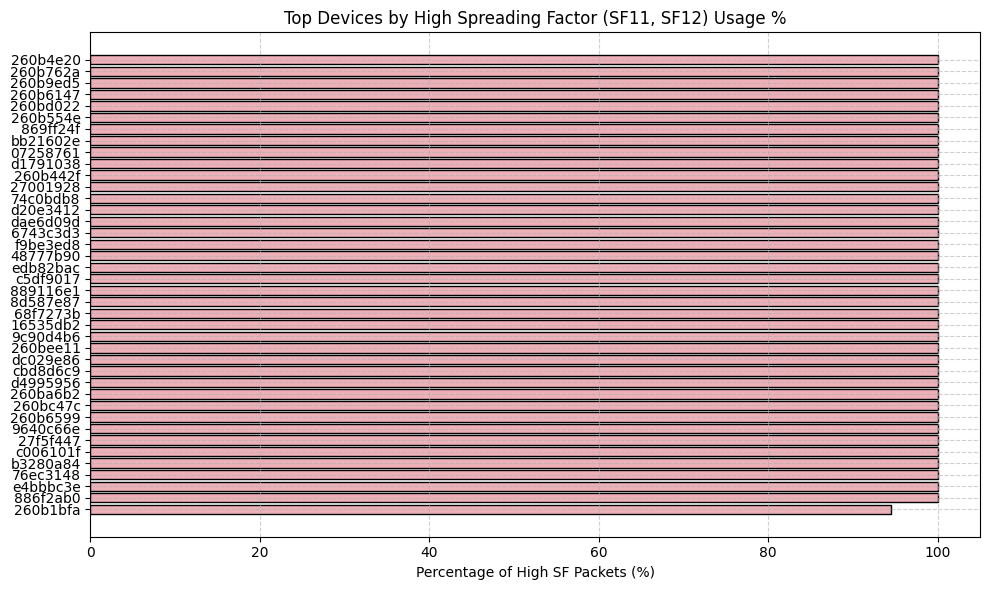

In [47]:
import matplotlib.pyplot as plt

# Select top N devices for clarity
top_devices = device_sf_summary.head(40)

plt.figure(figsize=(10, 6))
plt.barh(top_devices['DevAddr'].astype(str), top_devices['HighSF_Percentage'],
         color='#edafb8', edgecolor='black')
plt.xlabel('Percentage of High SF Packets (%)')
plt.title('Top Devices by High Spreading Factor (SF11, SF12) Usage %')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


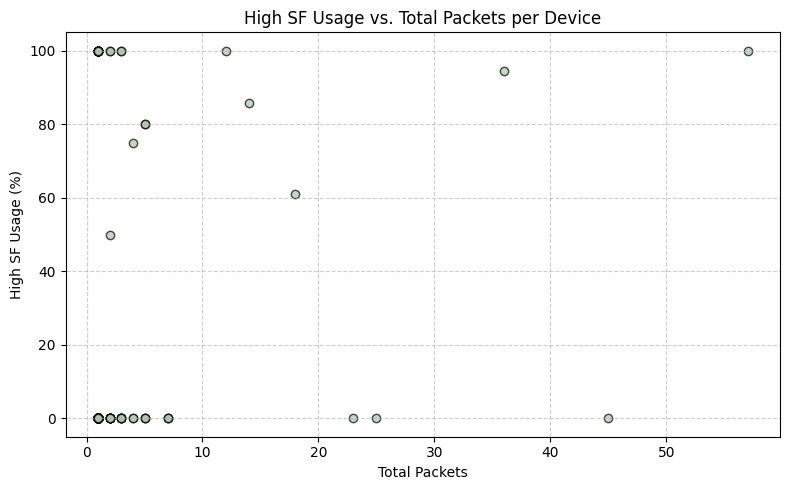

In [46]:
plt.figure(figsize=(8, 5))
plt.scatter(device_sf_summary['TotalPacketCount'],
            device_sf_summary['HighSF_Percentage'],
            color='#b0c4b1', edgecolor='black', alpha=0.7)
plt.xlabel('Total Packets')
plt.ylabel('High SF Usage (%)')
plt.title('High SF Usage vs. Total Packets per Device')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Per Device Loss Ratio
Loss Ratio= Total Expected Packets / Total Lost Packets

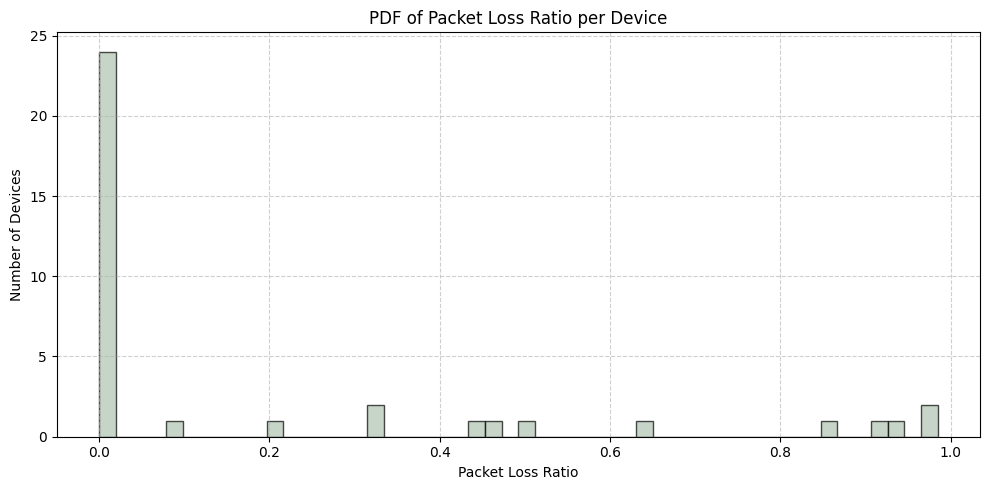

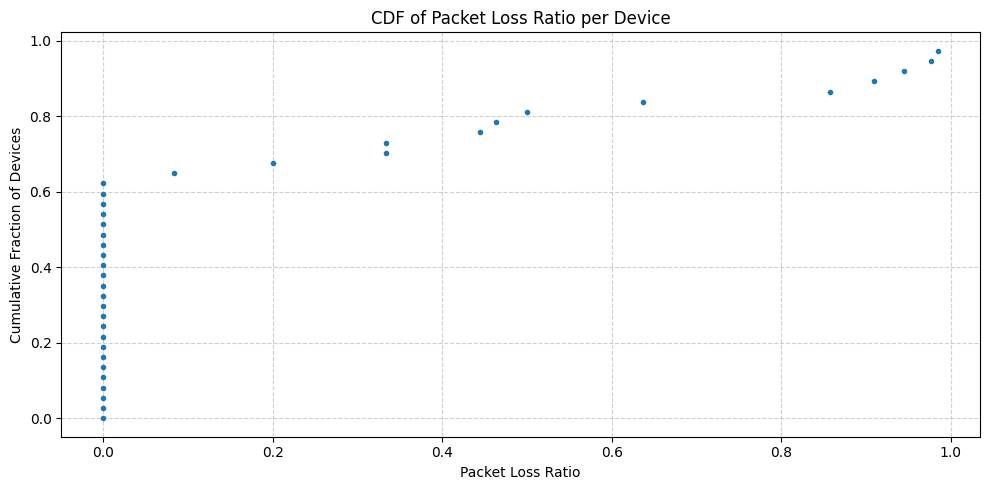

In [22]:
loss_ratios = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:  # avoid divide by zero
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)

loss_ratios = np.array(loss_ratios)

# Plot PDF
plt.figure(figsize=(10, 5))
plt.hist(loss_ratios, bins=50, edgecolor='black', alpha=0.7, color='#b0c4b1')
plt.title('PDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot CDF
plt.figure(figsize=(10, 5))
sorted_ratios = np.sort(loss_ratios)
cdf = np.arange(len(sorted_ratios)) / len(sorted_ratios)
plt.plot(sorted_ratios, cdf, marker='.', linestyle='none')
plt.title('CDF of Packet Loss Ratio per Device')
plt.xlabel('Packet Loss Ratio')
plt.ylabel('Cumulative Fraction of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Threshold: consider loss ratio > 0.5 as high loss

In [36]:
# Threshold: consider loss ratio > 0.5 as high loss
high_loss_devices = sorted_ratios[sorted_ratios > 0.5]
high_loss_indices = np.where(sorted_ratios > 0.5)[0]
high_loss_devaddrs = df_valid_packets.groupby('DevAddr').filter(
    lambda g: np.diff(g.sort_values('tmst')['FCnt'].values).sum() > 0
).groupby('DevAddr').size().iloc[high_loss_indices].index.tolist()

print("Devices with high downlink loss (>50%):")
print(high_loss_devaddrs)

Devices with high downlink loss (>50%):
['260bdd09', '260be229', '260be979', '260bf667', '27001975', '270340b6']


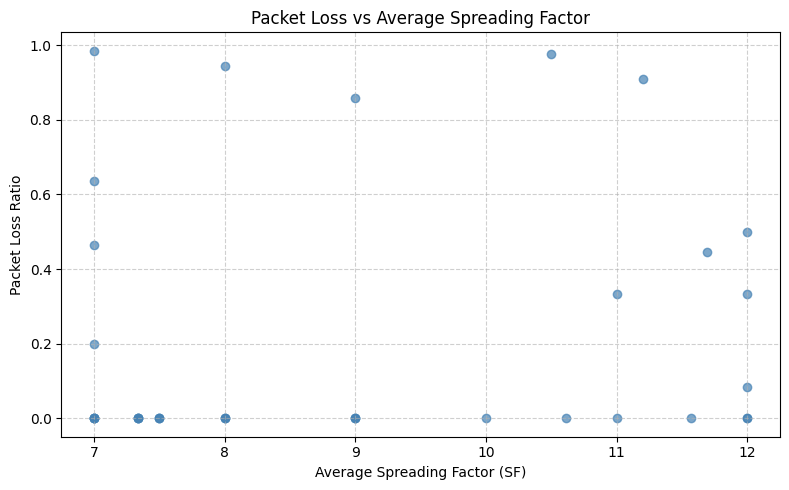

In [37]:
loss_ratios = []
loss_devaddrs = []

# Group by DevAddr
for dev, group in df_valid_packets[['DevAddr', 'FCnt', 'tmst']].groupby('DevAddr'):
    group_sorted = group.sort_values(by='tmst')
    fcnts = group_sorted['FCnt'].values
    fcnt_diffs = np.diff(fcnts)

    # Lost packets calculation
    lost_packets = np.sum(fcnt_diffs[fcnt_diffs > 1] - 1)
    total_expected = fcnts[-1] - fcnts[0]

    if total_expected > 0:
        loss_ratio = lost_packets / total_expected
        loss_ratios.append(loss_ratio)
        loss_devaddrs.append(dev)  # track matching DevAddr

# Now create the DataFrame properly
loss_sf_df = pd.DataFrame({
    'DevAddr': loss_devaddrs,
    'LossRatio': loss_ratios,
})

# Set DevAddr as index
loss_sf_df = loss_sf_df.set_index('DevAddr')

# Compute average SF per device (you can reuse this if already calculated)
df_valid_packets['sf_num'] = df_valid_packets['datr'].str.extract(r'SF(\d+)')[0].astype(int)
avg_sf_per_device = df_valid_packets.groupby('DevAddr')['sf_num'].mean()

# Join
loss_sf_df['AvgSF'] = avg_sf_per_device

# Drop any unmatched
loss_sf_df = loss_sf_df.dropna()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(loss_sf_df['AvgSF'], loss_sf_df['LossRatio'], alpha=0.7, color='#4682b4')
plt.xlabel('Average Spreading Factor (SF)')
plt.ylabel('Packet Loss Ratio')
plt.title('Packet Loss vs Average Spreading Factor')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Time analysis

In [23]:
from datetime import datetime
df_valid_packets['tmst_str'] = df_valid_packets['tmst'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [24]:
print(df_valid_packets.tmst_str.max())
print(df_valid_packets.tmst_str.min())

2025-05-14 20:55:18
2024-10-17 10:53:30


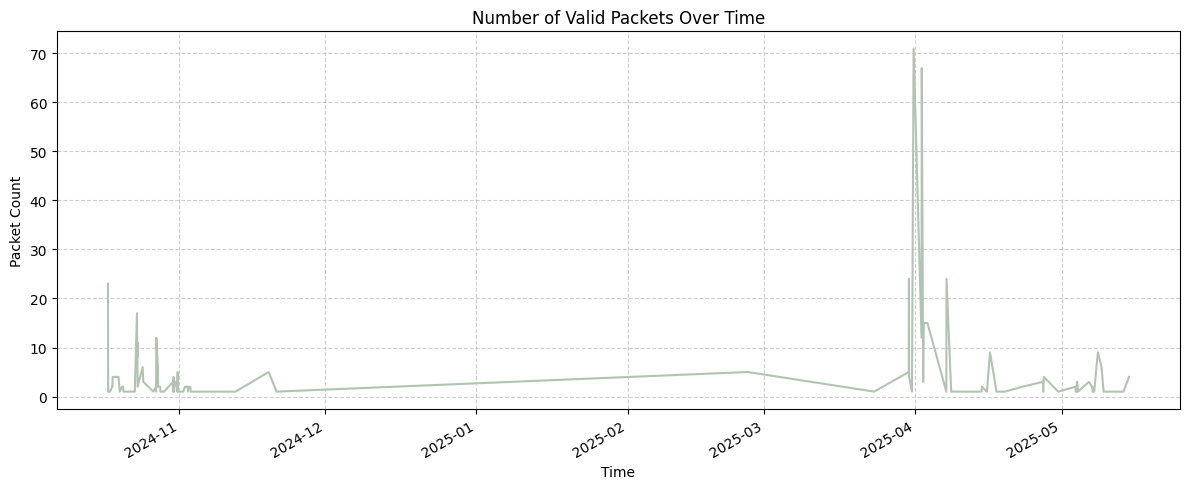

In [25]:
# Convert tmst_str back to datetime type
df_valid_packets['tmst_datetime'] = pd.to_datetime(df_valid_packets['tmst_str'], format='%Y-%m-%d %H:%M:%S')

# Get hourly info
df_valid_packets['time_bin'] = df_valid_packets['tmst_datetime'].dt.floor('1H')  # group by hour

# Count packets per time bin
packet_counts = df_valid_packets.groupby('time_bin').size()

plt.figure(figsize=(12, 5))
packet_counts.plot(kind='line', color="#b0c4b1")
plt.title('Number of Valid Packets Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [38]:
# Extract just the date from the timestamp
df_valid_packets['date'] = df_valid_packets['tmst_datetime'].dt.date

# Count packets per date
daily_counts = df_valid_packets.groupby('date').size()

# Get top 10 dates
top_10_dates = daily_counts.sort_values(ascending=False).head(10)

top_10_dates

date
2025-04-02    108
2025-03-31     72
2024-10-23     38
2025-03-30     33
2025-04-07     25
2024-10-17     25
2024-10-27     23
2025-04-27     16
2025-04-03     15
2024-10-31     13
dtype: int64

In [39]:
# Devices active on April 2
active_apr2 = df_valid_packets[df_valid_packets['date'] == pd.to_datetime('2025-04-02').date()]
print("Unique devices on April 2:", active_apr2['DevAddr'].nunique())
print("Top devices by packet count on April 2:")
print(active_apr2['DevAddr'].value_counts().head())

Unique devices on April 2: 41
Top devices by packet count on April 2:
DevAddr
260b633b    45
260bbabb     7
260b6c5a     5
260bc406     5
260b1a6b     3
Name: count, dtype: int64


In [40]:
# Count packets per SF
active_apr2['sf_num'] = active_apr2['datr'].str.extract(r'SF(\d+)')[0].astype(int)
sf_counts_apr2 = active_apr2['sf_num'].value_counts().sort_index()

print("SF distribution on April 2:")
print(sf_counts_apr2)

SF distribution on April 2:
sf_num
7     68
8      2
9     35
12     3
Name: count, dtype: int64


/var/folders/w2/sx8pt_m95sgc_08s7wwz4qz00000gn/T/ipykernel_40029/3766170141.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 🚀 Device Engagement Analysis

#### Top 10 Devices by Downlink Count

Top 10 devices by downlink count:
    DevAddr  downlink_count
0  260b4e20              57
1  260b633b              45
2  260b1bfa              36
3  05310421              25
4  260be979              23
5  260bb08d              18
6  260b61a5              14
7  260b762a              12
8  260bbabb               7
9  260bdbcb               7


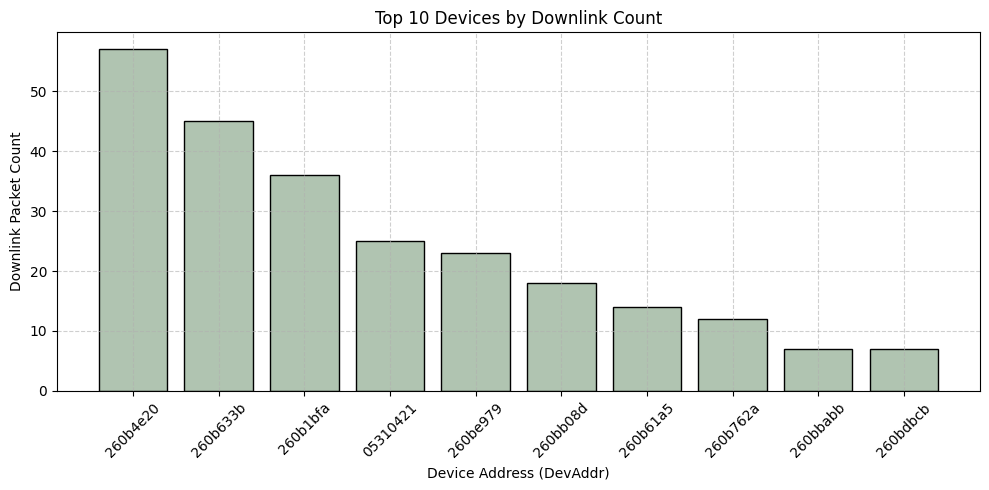

In [27]:
# 1️⃣ Count downlink packets per device
device_downlink_counts = df['DevAddr'].value_counts().reset_index()
device_downlink_counts.columns = ['DevAddr', 'downlink_count']

# 2️⃣ Top 10 devices
top_10_downlink_devices = device_downlink_counts.head(10)

print("Top 10 devices by downlink count:")
print(top_10_downlink_devices)

# 3️⃣ Plot
plt.figure(figsize=(10, 5))
plt.bar(top_10_downlink_devices['DevAddr'].astype(str), top_10_downlink_devices['downlink_count'], color='#b0c4b1', edgecolor='black')
plt.title('Top 10 Devices by Downlink Count')
plt.xlabel('Device Address (DevAddr)')
plt.ylabel('Downlink Packet Count')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Devices like 260b4e20 and 260b633b are likely the most heavily managed or critical devices (e.g., gateways, control nodes).
- The gap to the rest indicates fewer devices need frequent downlink commands — typical for many IoT deployments where only some nodes get frequent updates.
- This also suggests possible tiered device roles:

Top talkers → important sensors or control nodes.

Lower activity → standard sensors or end devices.

#### Identify One-Time Downlink Devices

In [28]:
# Identify devices with only one downlink
one_time_downlink_devices = device_downlink_counts[device_downlink_counts['downlink_count'] == 1]

print(f"Number of devices that received only one downlink: {len(one_time_downlink_devices)}")
print(one_time_downlink_devices)

Number of devices that received only one downlink: 170
      DevAddr  downlink_count
38   cf13d0b8               1
39   044e12a0               1
40   2d103948               1
41   869ff24f               1
42   3f97dfed               1
..        ...             ...
203  c0ba3c8e               1
204  899d75e8               1
205  3edd98cb               1
206  d81bf1bc               1
207  27001914               1

[170 rows x 2 columns]


- These 170 devices are probably low-maintenance devices (like sensors that don’t need dynamic reconfiguration).
- The remaining devices (with more than 1 downlink) are likely the ones that require ongoing control or monitoring.

### Hourly Downlink Traffic

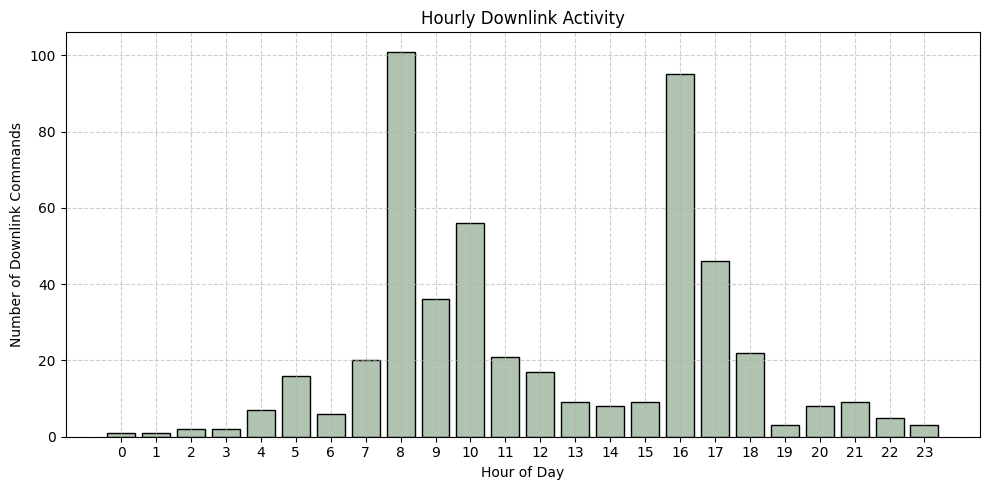

In [29]:

# Convert timestamps to datetime (if not done already)
df['datetime'] = pd.to_datetime(df['tmst'], unit='s')  # or 'ms' if your timestamps are in milliseconds

# Extract the hour of the day
df['hour'] = df['datetime'].dt.hour

# Count number of downlink commands per hour
hourly_downlink_counts = df['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(hourly_downlink_counts.index, hourly_downlink_counts.values, color='#b0c4b1', edgecolor='black')
plt.title('Hourly Downlink Activity')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Downlink Commands')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


- Two major spikes in downlink activity:

        Around 8–9 AM

        Around 3–4 PM

- Lulls during nighttime (midnight to early morning).
- Activity ramps up after 4 AM and peaks in two waves — probably aligned with network maintenance windows or device activity schedules.

####  Device Lifespan in Downlink

    DevAddr                 min                 max  lifespan_hours  \
0  0397df91 2025-03-30 17:09:14 2025-03-30 17:09:14        0.000000   
1  03e4cd3d 2024-10-19 14:18:30 2024-10-19 14:18:30        0.000000   
2  044e12a0 2025-04-02 18:00:38 2025-04-02 18:00:38        0.000000   
3  05310421 2024-10-24 13:29:04 2024-10-27 17:23:42       75.910556   
4  0669b635 2025-04-27 09:16:29 2025-04-27 09:16:29        0.000000   

   lifespan_days  
0        0.00000  
1        0.00000  
2        0.00000  
3        3.16294  
4        0.00000  


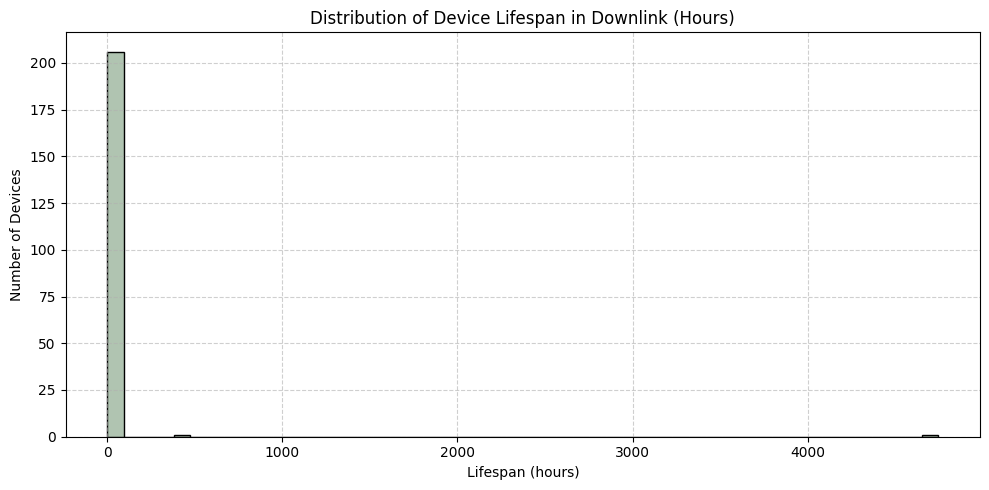

In [30]:
# Group by device and get first/last seen downlink
downlink_lifespan = df.groupby('DevAddr')['datetime'].agg(['min', 'max']).reset_index()

# Calculate lifespan (in hours and days)
downlink_lifespan['lifespan_hours'] = (downlink_lifespan['max'] - downlink_lifespan['min']).dt.total_seconds() / 3600
downlink_lifespan['lifespan_days'] = downlink_lifespan['lifespan_hours'] / 24

# Show top rows
print(downlink_lifespan.head())

# Plot histogram of lifespan (in hours)
plt.figure(figsize=(10, 5))
plt.hist(downlink_lifespan['lifespan_hours'], bins=50, color='#b0c4b1', edgecolor='black')
plt.title('Distribution of Device Lifespan in Downlink (Hours)')
plt.xlabel('Lifespan (hours)')
plt.ylabel('Number of Devices')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


-  The overwhelming majority of devices have zero or near-zero lifespan — they received a downlink only once or within a very short window.
-  A very small group of outlier devices has longer lifespans (1000+ hours / 40+ days).

### FPort Usage by Device

#### FPort Category Usage by Device

FPort_category  Control_pct  Application_pct
DevAddr                                     
0397df91                0.0            100.0
03e4cd3d                0.0              0.0
044e12a0                0.0            100.0
05310421              100.0              0.0
0669b635                0.0            100.0


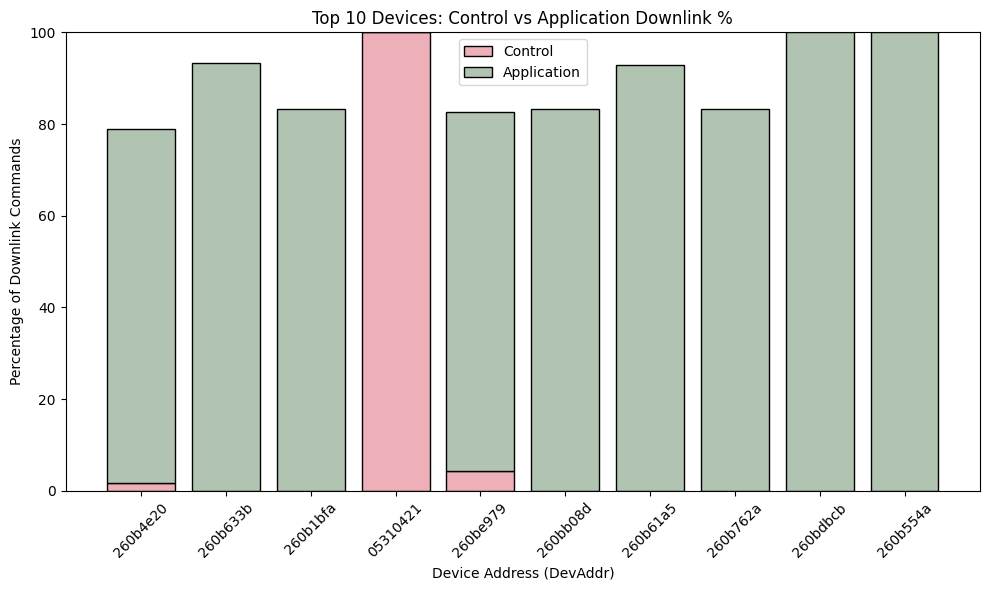

In [31]:
# Function to categorize FPort
def fport_category(fport):
    if fport == 0:
        return 'Control'
    elif 1 <= fport <= 223:
        return 'Application'
    elif 224 <= fport <= 255:
        return 'Reserved'
    else:
        return 'Unknown'

# Categorize FPort usage
df['FPort_category'] = df['FPort'].apply(fport_category)

# Count per device
fport_usage_by_device = df.groupby(['DevAddr', 'FPort_category']).size().unstack(fill_value=0)

# Calculate percentage usage
fport_usage_by_device['Total'] = fport_usage_by_device.sum(axis=1)
fport_usage_by_device['Control_pct'] = fport_usage_by_device.get('Control', 0) / fport_usage_by_device['Total'] * 100
fport_usage_by_device['Application_pct'] = fport_usage_by_device.get('Application', 0) / fport_usage_by_device['Total'] * 100

# Show top rows
print(fport_usage_by_device[['Control_pct', 'Application_pct']].head())

# Optional: Plot a few example devices as stacked bar chart
top_devices = fport_usage_by_device.sort_values(by='Total', ascending=False).head(10)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_devices.index.astype(str), top_devices['Control_pct'], label='Control', color='#edafb8', edgecolor='black')
plt.bar(top_devices.index.astype(str), top_devices['Application_pct'], bottom=top_devices['Control_pct'], label='Application', color='#b0c4b1', edgecolor='black')
plt.title('Top 10 Devices: Control vs Application Downlink %')
plt.xlabel('Device Address (DevAddr)')
plt.ylabel('Percentage of Downlink Commands')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

-  Most of the top 10 devices receive almost exclusively application data (green bars).
-  Only one device (05310421) has 100% control messages (red bar) — suggesting it’s a device primarily used for configuration or management.
-  Another device (260b4e20) has ~5% control commands — indicating occasional reconfiguration or periodic control.

#### Identify Outlier Devices

In [33]:
# Threshold for considering a device as control-heavy
control_threshold = 50  # e.g., more than 50% control messages

# Identify control-heavy devices
control_heavy_devices = fport_usage_by_device[fport_usage_by_device['Control_pct'] > control_threshold]

print(f"Number of control-heavy devices (> {control_threshold}% control): {len(control_heavy_devices)}")
print(control_heavy_devices[['Control_pct', 'Application_pct']])

Number of control-heavy devices (> 50% control): 5
FPort_category  Control_pct  Application_pct
DevAddr                                     
05310421              100.0              0.0
267d1185              100.0              0.0
4a24a17e              100.0              0.0
4f7cef80              100.0              0.0
68ac0adb              100.0              0.0


-  5 devices have 100% control messages (no application data at all).
-  These are likely pure control endpoints (no data collection role, only receive network commands).